In [5]:
!git status

On branch rakeshw_final
Your branch is up to date with 'origin/rakeshw_final'.

Changes not staged for commit:
  (use "git add <file>..." to update what will be committed)
  (use "git checkout -- <file>..." to discard changes in working directory)

	modified:   models/Rakesh_models.ipynb

Untracked files:
  (use "git add <file>..." to include in what will be committed)

	cleantrain/
	cleantrain_8/
	data/final_check_sum.p
	data/id_lookup.p
	data/models/
	data/test.csv
	data/test.p
	data/testdup.p
	data/train.p
	data/traindup.p
	data/training.csv
	lightning_logs/
	utils/__pycache__/


It took 2.03 seconds to enumerate untracked files. 'status -uno'
may speed it up, but you have to be careful not to forget to add
new files yourself (see 'git help status').
no changes added to commit (use "git add" and/or "git commit -a")


In [ ]:
!pip install pytorch-lightning

     |████████████████████████████████| 839kB 7.1MB/s 
     |████████████████████████████████| 829kB 27.6MB/s 
     |████████████████████████████████| 276kB 37.0MB/s 
     |████████████████████████████████| 112kB 45.2MB/s 
     |████████████████████████████████| 184kB 59.1MB/s 
     |████████████████████████████████| 1.3MB 35.4MB/s 
     |████████████████████████████████| 143kB 42.3MB/s 
     |████████████████████████████████| 296kB 29.1MB/s 
  Created wheel for future: filename=future-0.18.2-cp37-none-any.whl size=491058 sha256=66f957ad5aebe7e527de4803f02bf97240c2ab768e9fe0bc5e577f44d2d6a821
  Stored in directory: /root/.cache/pip/wheels/8b/99/a0/81daf51dcd359a9377b110a8a886b3895921802d2fc1b2397e
  Created wheel for PyYAML: filename=PyYAML-5.3.1-cp37-cp37m-linux_x86_64.whl size=44620 sha256=922cef5b1238682231cb6b4be89cbcecd9191f8bb9e6c64b6a7d1a4c84533c38
  Stored in directory: /root/.cache/pip/wheels/a7/c1/ea/cf5bd31012e735dc1dfea3131a2d5eae7978b251083d6247bd
Successfully built future

In [ ]:
cd /content/drive/MyDrive/w207/blackboxes/utils/

/content/drive/MyDrive/w207/blackboxes/utils


In [ ]:
#Set the utils path to point to the utils directory locally
UTILS_PATH = "utils/"
IMG_SIZE = 96

import os, sys
sys.path.append(UTILS_PATH)
from load_models import LoadTrainModels
from predict_models import PredictModels
from transform_data import TransformData
import imp
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F
from torch import nn
from torch import optim

from torchvision import transforms
from torch.utils.data import DataLoader, Dataset, random_split
from torch.utils.data.sampler import SubsetRandomSampler

import pytorch_lightning as pl
from torchmetrics import MeanSquaredError as MSE

In [ ]:
# https://niko-gamulin.medium.com/resnet-implementation-with-pytorch-from-scratch-23cf3047cb93
# Pytorch Lightning Tutorials to build networks : https://www.youtube.com/watch?v=DbESHcCoWbM&list=PLaMu-SDt_RB5NUm67hU2pdE75j6KaIOv2&index=3

### 
# This is a basic ResNet-18 building-block. Contains 2 Conv-layers and a residual-identity
# downsample layer.
###
class Block(pl.LightningModule):
    def __init__(self, in_channels, out_channels, identity_downsample=None, stride=1):
        super(Block, self).__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=1, stride=1, padding=0)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()

        self.identity_downsample = identity_downsample

        # Building block's main-structure. Input of this block is bypassed and added to its output.
        self.block_main = nn.Sequential(
            self.conv1,
            self.bn,
            self.relu,
            self.conv2,
            self.bn,
            self.relu
        )

    def forward(self, x):
        identity = x
        x = self.block_main(x)

        if self.identity_downsample is not None:
            identity = self.identity_downsample(identity)

        # add identity to output of block before activation-function.
        x += identity
        x = self.relu(x)
        return x

In [ ]:
class ResNet(pl.LightningModule):
    def __init__(self, data_file, num_classes, batch_size):
        super(ResNet, self).__init__()
        self.data_file = data_file
        self.batch_size = batch_size

        self.train_set, self.val_set = self.__load_data__()
        
        # Input Layer
        self.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3)
        self.bn = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # ResNetLayers
        self.layer1 = self.__make_layers__(in_channels=64, out_channels=64, stride=1)
        self.layer2 = self.__make_layers__(in_channels=64, out_channels=128, stride=2)
        self.layer3 = self.__make_layers__(in_channels=128, out_channels=256, stride=2)
        self.layer4 = self.__make_layers__(in_channels=256, out_channels=512, stride=2)

        # Output Layers
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

        # Loss Function
        self.loss = nn.MSELoss()

        # Define the model structure
        self.model = nn.Sequential(
            # first Conv-layer
            self.conv1,
            self.bn,
            self.relu,
            self.maxpool,

            # residue-blocks
            self.layer1,
            self.layer2,
            self.layer3,
            self.layer4,
        )

        # Training Metrics
        self.epoch_train_losses = []
        self.epoch_val_losses = []


    def __load_data__(self):
        model_filename = str(self.data_file).replace('.p', '').strip()
        model_name = "".join((model_filename,"_rakesh"))
        
        data = FaceKeypointsDataset(self.data_file)

        validation_split = 0.1
        data_size = len(data)
        indices = list(range(data_size))
        split = int(np.floor(validation_split * data_size))
        train_indices, val_indices = indices[split:], indices[:split]
        
        # Creating PT data samplers and loaders:
        train_sampler = SubsetRandomSampler(train_indices)
        valid_sampler = SubsetRandomSampler(val_indices)

        train_loader = DataLoader(data, batch_size=self.batch_size, 
                                                  sampler=train_sampler)
        validation_loader = DataLoader(data, batch_size=self.batch_size,
                                                        sampler=valid_sampler)
        return train_loader, validation_loader


    def __make_layers__(self, in_channels, out_channels, stride):
        layers = []

        ### Residual path for each Block-layer
        identity_downsample = nn.Sequential(nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride),
                                            nn.BatchNorm2d(out_channels))
        
        layers.append(Block(in_channels, out_channels, identity_downsample, stride))
        layers.append(Block(out_channels, out_channels))
        return nn.Sequential(*layers)


    def forward(self, x):
        # x = x.float()
        x = self.model(x)

        # Output Layers
        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)
        return x

    def configure_optimizers(self):
        self.optimizer = optim.Adam(self.parameters(), lr=0.001)
        return self.optimizer

    def training_step(self, batch, batch_index):
        x, y = batch
        x = batch[x]
        y = batch[y]

        b_size = x.size(0)
        x = x.view(b_size, -1, IMG_SIZE, IMG_SIZE)

        # Run 
        logits = self(x)

        # objective-function (loss) calculation
        J = torch.sqrt(self.loss(logits, y))

        # self.log('train_loss', J, on_step=True, on_epoch=True, prog_bar=True)

        # mse = MSE(logits, y)
        # pgrs_bar = {'MSE': mse}
        
        # PTLightning automatically does these steps:
        # 1. zero_grad() # settings gradients to zero before each backpropogation
        # 2. J.backward() # backpropogation of loss
        # 3. optimizer.step() # stochastic gradient descent takes one step in the right direction of lowered loss.
        # 4. Takes care of what devices are available and where data needs to be pushed to (CPU/GPU/TPU)

        # return the Loss data from the training-step
        # Loss is a reserved-word and a key indicating loss. The training steps returns loss as a dict.
        return {'loss': J}
      
    def validation_step(self, batch, batch_index):
        results = self.training_step(batch, batch_index)
        return results

    def training_epoch_end(self, train_step_outputs):
        # collections of validation-steps for all batches in this epoch
        avg_train_loss = torch.tensor([x['loss'] for x in train_step_outputs]).mean()

        self.log('train_loss', avg_train_loss)

        self.epoch_train_losses.append(avg_train_loss.item())

    def validation_epoch_end(self, val_step_outputs):
        # collections of validation-steps for all batches in this epoch
        avg_val_loss = torch.tensor([x['loss'] for x in val_step_outputs]).mean()

        self.log('val_loss', avg_val_loss)

        self.epoch_val_losses.append(avg_val_loss.item())

    # load train-data here; there are multiple data-files and this loads all of them into loaders.
    def train_dataloader(self):
        return self.train_set

    def val_dataloader(self):
        return self.val_set

In [ ]:
# https://medium.com/diving-in-deep/facial-keypoints-detection-with-pytorch-86bac79141e4
class FaceKeypointsDataset(Dataset):
    '''Face Keypoints Dataset'''
    def __init__(self, datafilename):
        self.datafile = datafilename
        with open(self.datafile, "rb") as data_file:
            self.data = pickle.load(data_file).drop(['level_0', 'check_sum', 'index'], axis=1,errors='ignore')
        #Adding a transform data object if I want to do any transformations in this file
        transformdata = TransformData()
        flipped = transformdata.FlipHorizontal(self.data)
        self.data = pd.concat([self.data,flipped])
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        image = self.data.iloc[idx, -1]
        keypoints = None

        image = image.reshape(-1, IMG_SIZE)
        image = image / 255.0
        
        keypoints = self.data.iloc[idx, :-1].values.astype(np.float32)

        return {
            'image': torch.tensor(image, dtype=torch.float),
            'keypoints': torch.tensor(keypoints, dtype=torch.float),
        }

In [3]:
cd /content/drive/My Drive/w207/blackboxes

/content/drive/My Drive/w207/blackboxes


GPU available: False, used: False
TPU available: False, using: 0 TPU cores


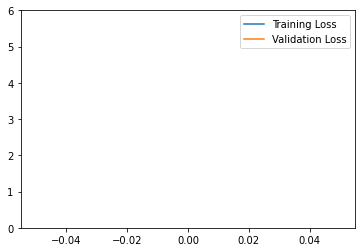

GPU available: False, used: False
TPU available: False, using: 0 TPU cores


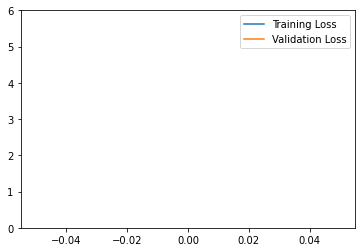

GPU available: False, used: False
TPU available: False, using: 0 TPU cores


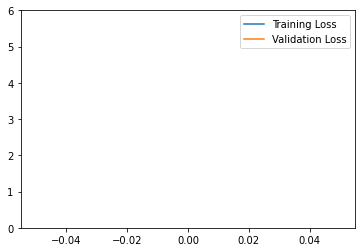

GPU available: False, used: False
TPU available: False, using: 0 TPU cores


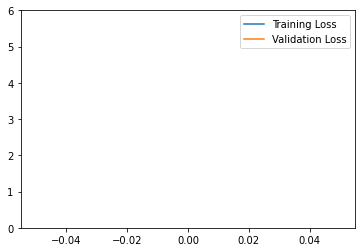

GPU available: False, used: False
TPU available: False, using: 0 TPU cores


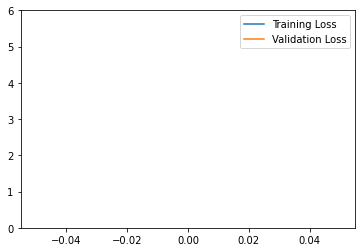

GPU available: False, used: False
TPU available: False, using: 0 TPU cores


In [ ]:
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import EarlyStopping

data_file_path = "cleantrain_8/"
model_details_directory = "data/models/rakesh/"
files = os.listdir(data_file_path)
epoch_lim = 1
gpu_lim = 0

for file in files:
    clean_file = "".join((data_file_path, file))

    model = ResNet(data_file=clean_file, num_classes=8, batch_size=64)
    logger = TensorBoardLogger(model_details_directory+"tb_logs", name="".join((file, "_model_logs")))

    trainer = pl.Trainer(logger=logger, progress_bar_refresh_rate=20, max_epochs=epoch_lim, gpus=gpu_lim, auto_scale_batch_size="binsearch", callbacks=[EarlyStopping(monitor='val_loss', patience=10)])
    # trainer.tune(model)
    trainer.fit(model)

    model_pickle_file = "".join((model_details_directory, file, "model"))
    torch.save(model, model_pickle_file)

    plt.plot(range(len(model.epoch_train_losses)), model.epoch_train_losses, label="Training Loss")
    plt.plot(range(len(model.epoch_val_losses)), model.epoch_val_losses, label="Validation Loss")
    plt.legend(loc="upper right")
    plt.ylim([0, 6])
    plt.show()

[53.821388244628906, 8.263504981994629, 5.925318717956543]


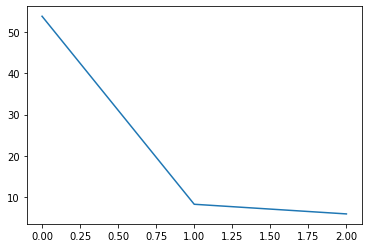

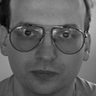

In [ ]:
from google.colab.patches import cv2_imshow as cv2

print("train_data with flipped:", train_data.shape)
print(train_data['image'].shape)
image_sample = train_data['image'].values[464].reshape(96, 96)

cv2(image_sample)

In [ ]:
loaders = []

file_path = "cleantrain/"
files = os.listdir(file_path)
clean_file = "".join((file_path,filename))

#For every version of a cleaned Train file in CleanTrain directory, create and save a model
for filename in files:
    # load model.train_dataloader(filename)

return loaders

Opening file:  clean_o_outliers.p
cleantrain/clean_o_outliers.p
Train Shape: (7020, 31)
Begin model and train:
Model name: clean_o_outliers_rakesh
